# Trajectory classification - analyses using RMSD

To determine the melting temperature, one often needs to determine reference structures. These reference strctures would represent different meta-stable folded configurations. In this example, we perform this analysis for a palindromic seven residue DNA hairpin.

## The trajectory

The system to be studied in this particular example involves several stable or metastable configurations which differ in their structure only very little. The natively folded strcture is the most populated. It involves the formation of a three nucleotide loop and then a zipping of the stem bases of the single stranded DNA. The central nucleotide in the loop is stacked on one of the other two nucleotides, which form a sheared base-pair (allowing them to form a loop with only three nucleotides - it takes 4 or more for RNA). The "misfolded" states identified involve these possible differences with respect to the natively folded state

1. A switch between syn and anti configuration of the loop residues
2. Stacking on the nucleotide different from the one in the native state
3. Zipping of the step without the base-pairing of the loop residues - they merely stack as well

These states can be separated from the natively folded structures without performing explicit clustering using a simple RMSD histogram analysis (coupled with a loop native contacts analysis - this is a work in progress). It is not necessarily a replacement for clustering but could be a way to get an intuition for the conformations taken by the molecule while obtaining some representative structures with respect to which one can perform the melting temperature analyses.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import MDAnalysis as mda
from MDAnalysis.analysis import rms, distances
from MDAnalysis import Writer as mdawriter
from MDAnalysis.transformations import unwrap

from typing import List
from numpy.typing import NDArray

from pathlib import Path
import os
import re

from mc_trex.post_processing import dna_non_bonded, native_contacts, traj_classification
from mc_trex.post_processing.fit_func import sigmoid_for_dist, sigmoid_for_ang

In [2]:
top = "./example1.prmtop"
trj = "./example1.nc"

In [197]:
wrapped_traj = mda.Universe(top, trj)

## Using RMSD to separate frames

We begin by 
1. loading trajectory
2. selecting 3 random frames from the complete trajectory to serve as the references
3. calculating the RMSD with respect to these frames
4. generating histograms of these RMSD time series
5. separating peaks

Repeating this process along with some observation of the placement of the RMSD values can help iteratively separate frames. Since the RMSD distributions usually have a Gaussian-like spread about a mean value, we can expect there to be some contamination of the identified groups. 

In [246]:
# RMSDAnalysis instance for example1 
ra = traj_classification.RMSDAnalysis()

In [247]:
# Native contacts analysis instance for example1
nc = traj_classification.NativeContactAnalysis()

The trajectory needs to be unwrapped for the analyses to be robust and general.

In [200]:
wrapped_coords = wrapped_traj.trajectory.timeseries(atomgroup=traj.select_atoms("all"))

In [206]:
unwrap = mda.transformations.unwrap(ag=wrapped_traj.select_atoms("all"))

In [207]:
wrapped_traj.trajectory.add_transformations(unwrap)

In [210]:
coords = wrapped_traj.trajectory.timeseries()

In [214]:
if np.all(np.equal(coords, wrapped_coords)):
    print("Nothing happened.")
else:
    print("Unwrapping changed the trajectory.")

Nothing happened.


In [251]:
traj = mda.Universe(top, coords)

First, we extract 3 random frames from the trajectory to use as references. This can be changed to some other value.

In [219]:
nrefs = 3
refs = np.random.randint(low=0, high=traj.trajectory.n_frames, size=nrefs)

Next we extract the frames and create universes.

In [222]:
refs1 = [mda.Universe(top, coords[idx, :, :]) for idx in refs]

In [254]:
rmsds1 = ra.get_similarity_metric(traj, refs1, filenames=[str(i + 1) + ".nc" for i in range(3)], select="nucleic and not type H*") 

In [283]:
hist1 = ra.bin_frames(rmsds1, bins=1000)

Instead of choosing `auto`, the bin count was explicitly set to have a sufficient number bins considering the large number of frames.

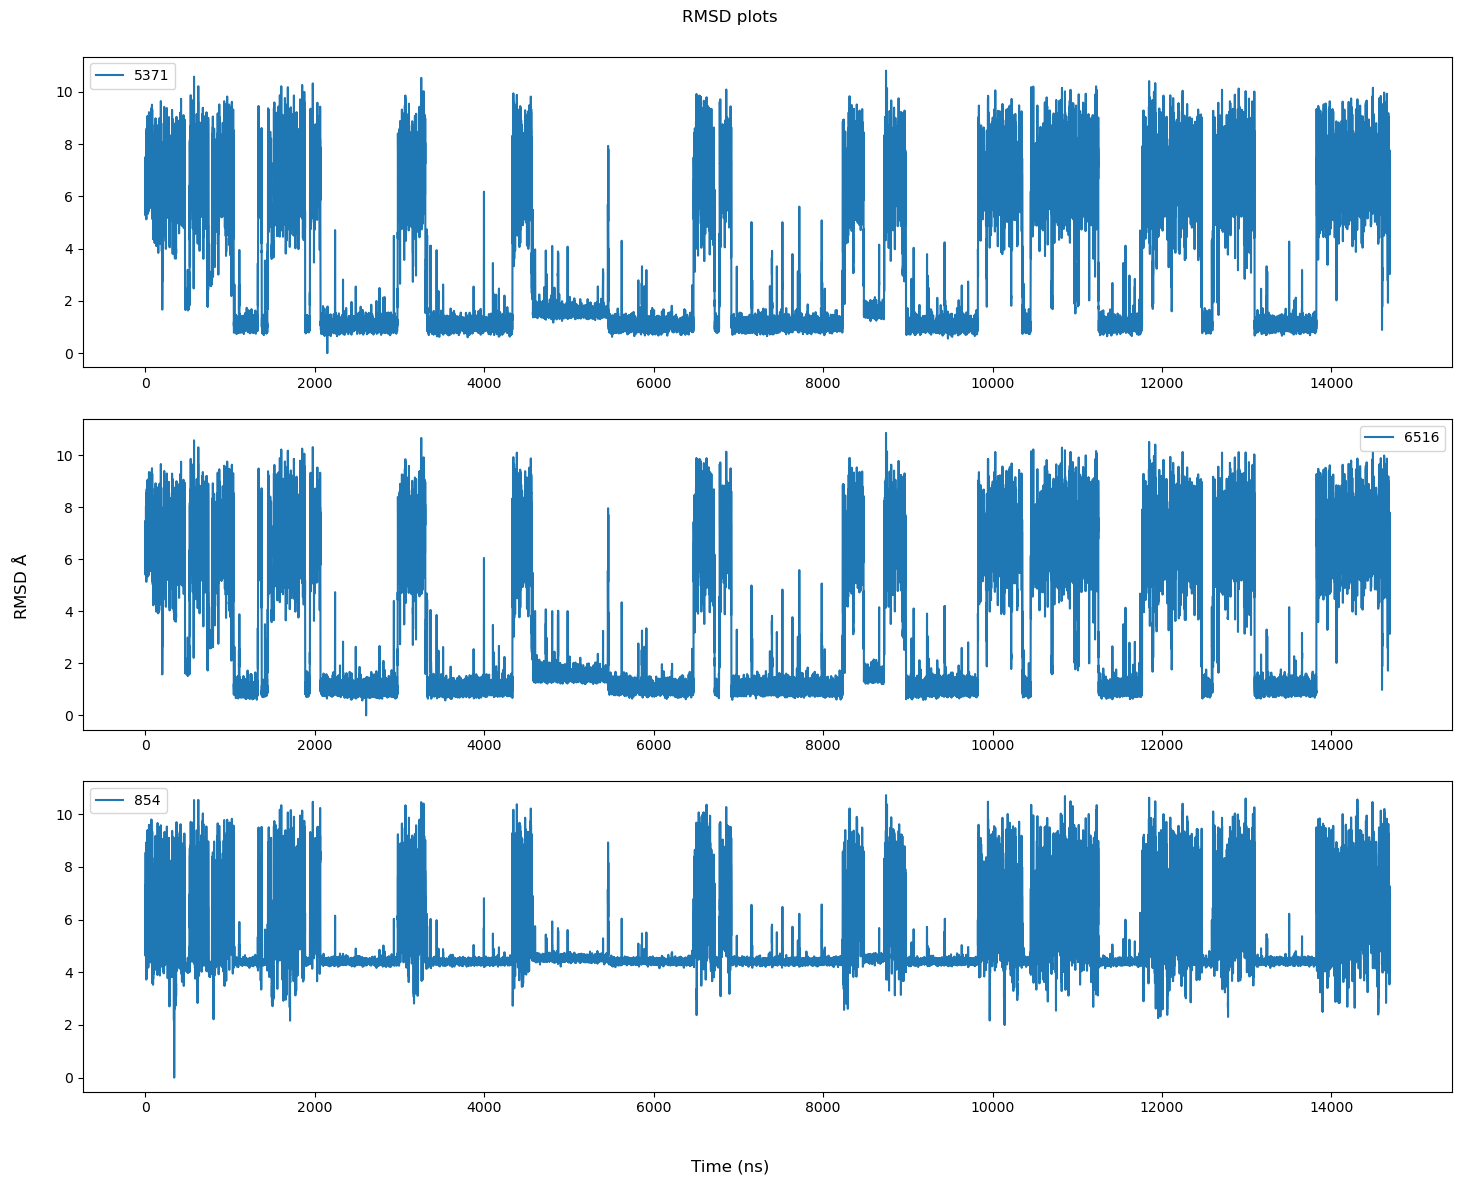

In [294]:
fig, axs = plt.subplots(nrows=3, figsize=(15, 12))

for rmsd, ax, refidx in zip(rmsds1, axs.flat, refs):
    ax.plot(np.arange(rmsds1[0].shape[0])*0.4, rmsd, label=refidx)
    ax.legend()
fig.supxlabel("Time (ns)")
fig.supylabel(r"RMSD $\mathrm{\AA}$")
fig.suptitle("RMSD plots")
fig.tight_layout(pad=2)

In [302]:
cuts1 = ra.get_cuts(hist1, max_components=10, height=20)

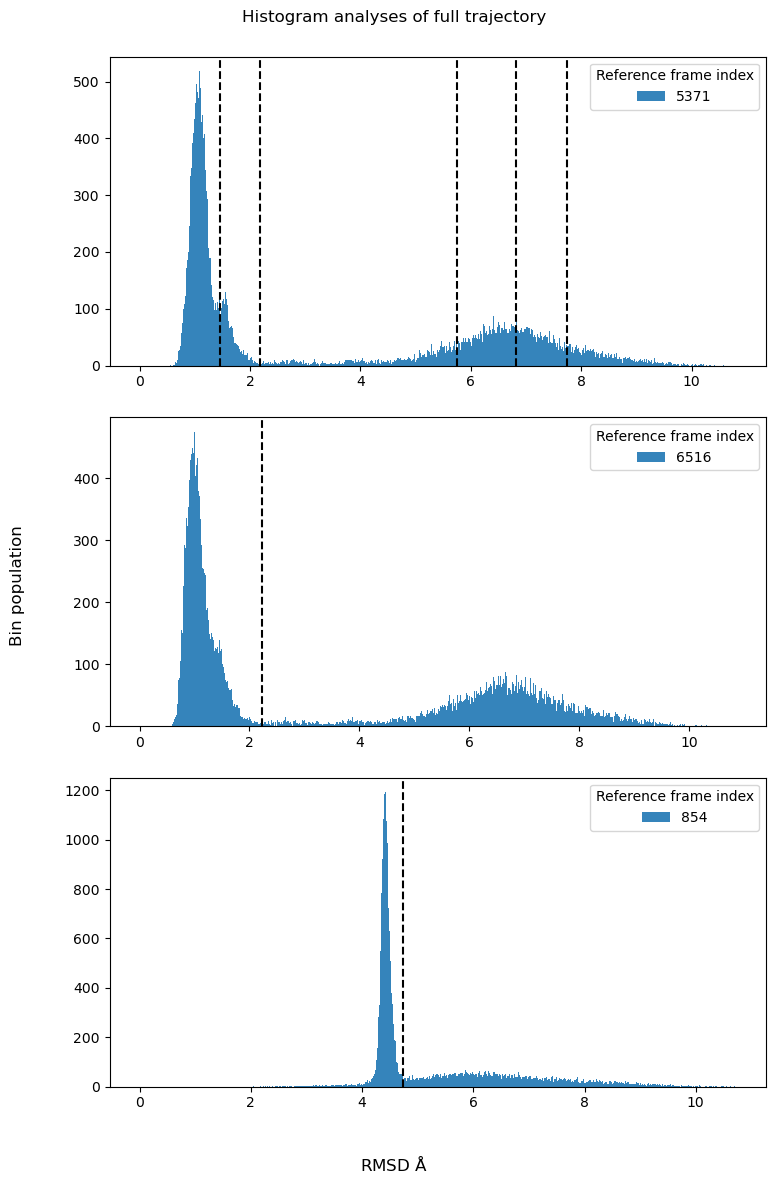

In [303]:
fig, axs = plt.subplots(nrows=3, figsize=(8, 12))

for cut, hist, idx, ax in zip(cuts1, hist1, refs, axs.flat):
    bin_centers = (hist[1][1:] + hist[1][:-1]) / 2
    ax.bar(bin_centers, hist[0], 
            label=str(idx), 
            width=(bin_centers[1] - bin_centers[0]),
            alpha=0.9)
    
    for c in cut:
        if c is not None:
            ax.axvline(c, color='k', ls='--')
    
    ax.legend(title="Reference frame index")
    
fig.supxlabel(r"RMSD $\mathrm{\AA}$")
fig.supylabel("Bin population")
fig.suptitle("Histogram analyses of full trajectory")
fig.tight_layout(pad=2)


From above, the first one has several identified regions, which we shall further analyze.

In [328]:
# Using refs[0] and the corresponding RMSD - rmsds1[0] for analyses
cuts = np.append([0], np.array(cuts1[0])[np.not_equal(cuts1[0], None)])
rmsds = rmsds1[0]
peaks = [np.where(np.logical_and(np.less(rmsds, high), np.greater_equal(rmsds, low)))[0] for low, high in zip(cuts[:4], cuts[1:5])]

In [337]:
cluster_counter = 1
c_traj_paths = []
for peak in peaks:
    u = mda.Universe(top, coords[peak])
    
    for ts, pos in zip(u.trajectory, coords[peak, :, :]):
        ts.positions = pos
    
    with mdawriter("cluster" + str(cluster_counter) +".nc", u.atoms.n_atoms) as w:
        for ts in u.trajectory:
            w.write(u)

    c_traj_paths.append(Path.cwd().joinpath("cluster" + str(cluster_counter) +".nc").as_posix())
    
    cluster_counter += 1

## Second set of RMSDs

The analyses will be performed for the first three clusters, the last one is assumed to only contain unfolded structures.

In [419]:
# Cluster trajectories extracted next
c_trajs1 = [mda.Universe(top, c_path) for c_path in c_traj_paths[:-1]]

In [420]:
# Generate reference frame indices for each cluster
c_refs1_ = [np.random.randint(low=0, high=len(peak), size=nrefs) for peak in peaks[:-1]]

In [422]:
c_coords = [c_traj.trajectory.timeseries() for c_traj in c_trajs1]

In [423]:
c_refs1 = [[mda.Universe(top, c_coord[c_ref, :, :]) for c_ref in c_refs] for c_refs, c_coord in zip(c_refs1_, c_coords)]

In [424]:
rmsds1 = [ra.get_similarity_metric(c_traj, c_refs, filenames=["1.nc", "2.nc", "3.nc"], select="nucleic and not type H*") for c_traj, c_refs in zip(c_trajs1, c_refs1)]
Path.unlink("./1.nc")
Path.unlink("./2.nc")
Path.unlink("./3.nc")

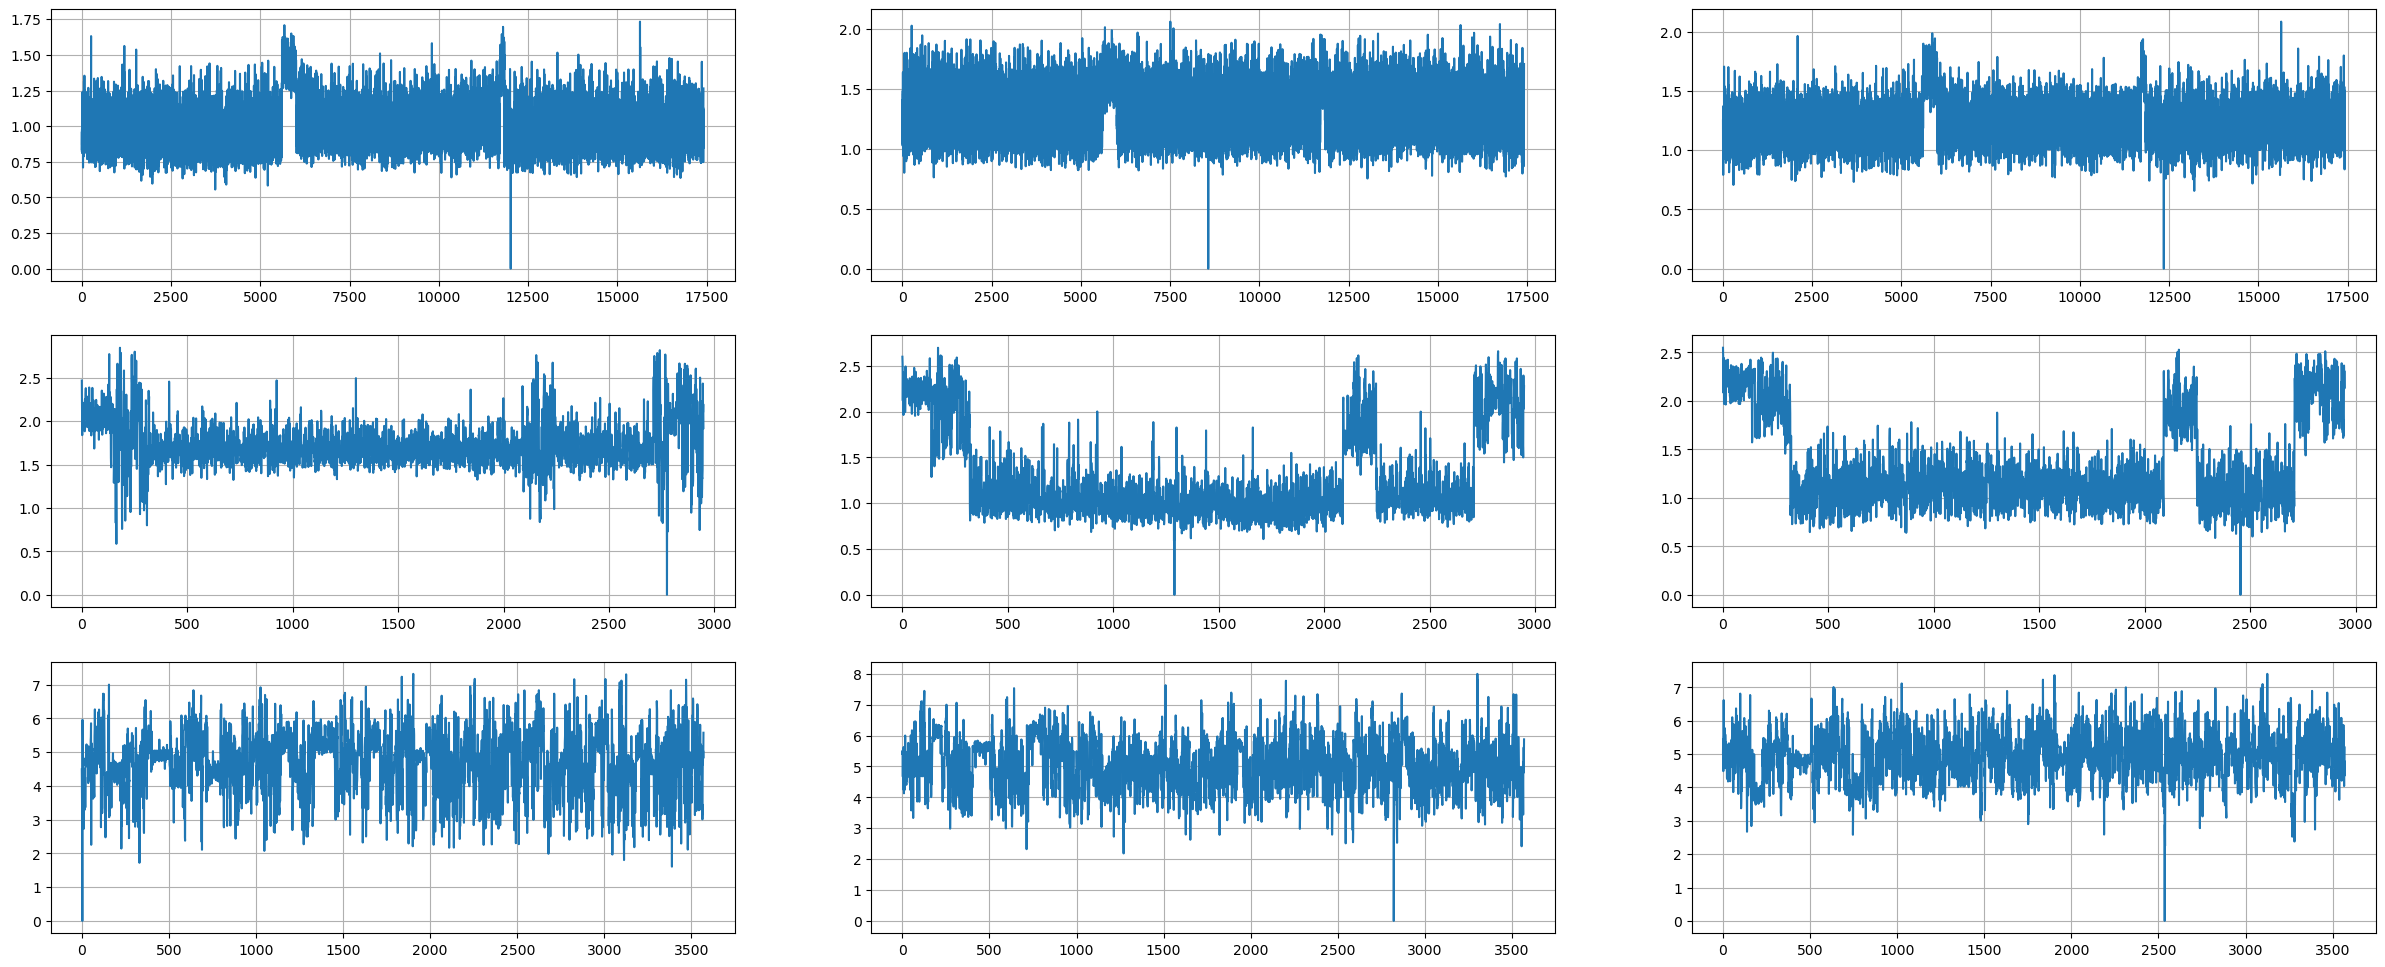

In [425]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30, 12))

for rmsd_peak, axi in zip(rmsds1, axs):
    for rmsd_ref, ax in zip(rmsd_peak, axi):
        ax.plot(rmsd_ref)
        ax.grid(True)

In [440]:
bin_rmsds1 = [ra.bin_frames(rmsd1, bins=100) for rmsd1 in rmsds1]

In [441]:
cuts1 = [ra.get_cuts(bin_rmsd1, max_components=10, height=0) for bin_rmsd1 in bin_rmsds1]

It might also be necessary to manually choose the reference frame when the population of outliers is really low. This is the case in the first peak i.e. the first row of RMSD plots. We clearly see that there are two regions which stand out. Another method to deal with this would be to plot the histogram and manually select a cut-off. A third possible way to treat this would be change the parameters of the function that computes cut-offs. 

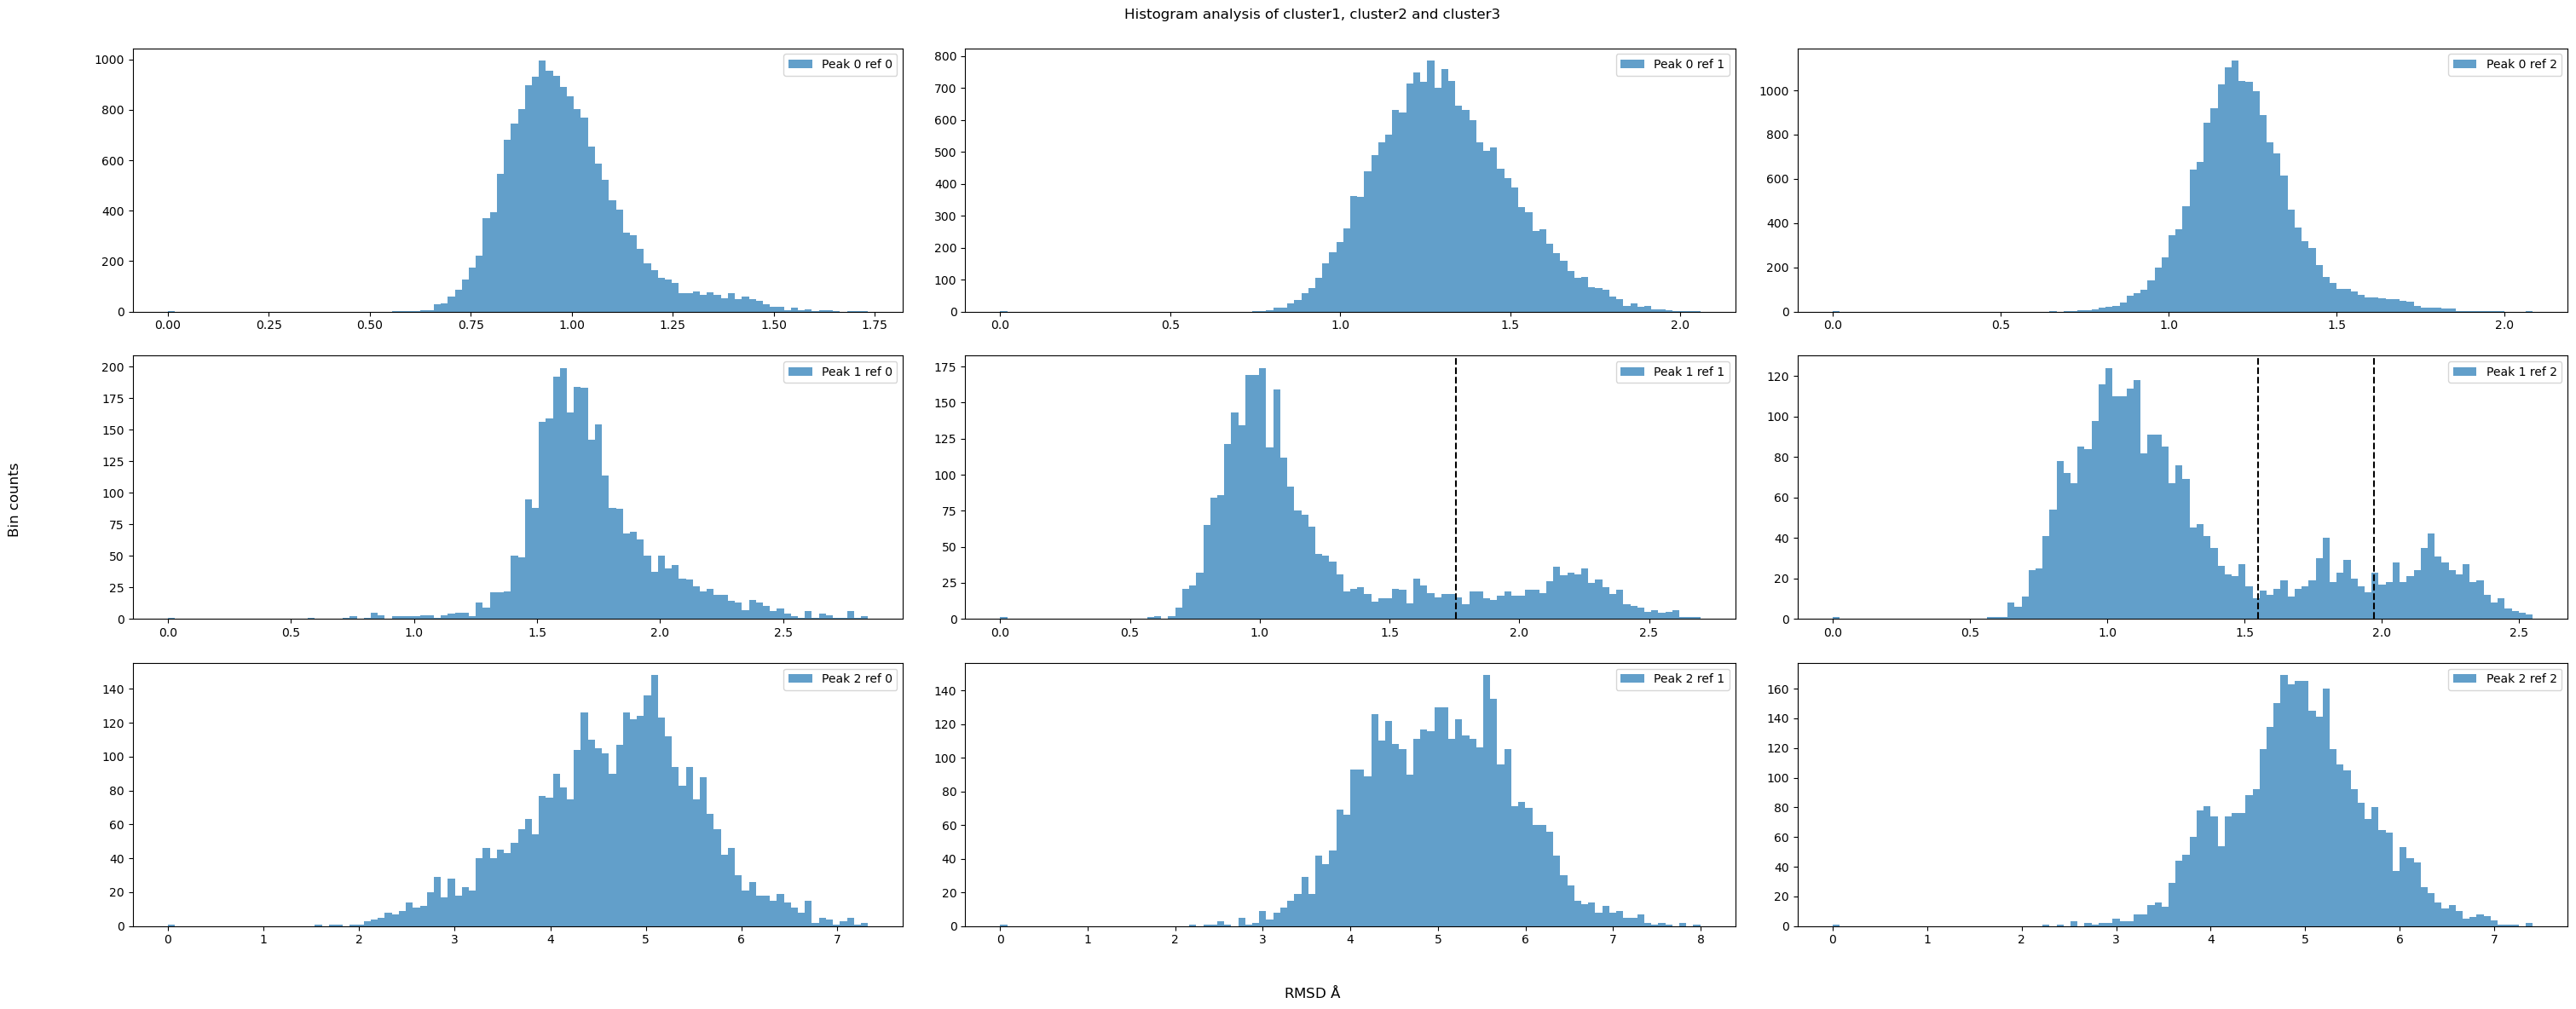

In [442]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30, 12))

fig.suptitle("Histogram analysis of cluster1, cluster2 and cluster3")
fig.supxlabel(r"RMSD $\mathrm{\AA}$")
fig.supylabel("Bin counts", x=-0.01)

for i in range(len(c_trajs)-1):
    peak_rmsd_hist = bin_rmsds1[i]
    peak_hist_cuts = cuts1[i] 
    peak_axs = axs[i]
    
    for j in range(3):
        ref_rmsd_hist = peak_rmsd_hist[j]
        ref_hist_cuts = peak_hist_cuts[j] 
        ax = peak_axs[j]
        label = c_refs1_[i][j]
        
        bin_centers = (ref_rmsd_hist[1][1:] + ref_rmsd_hist[1][:-1]) / 2
        bin_width = bin_centers[1] - bin_centers[0]
        
        ax.bar(bin_centers, ref_rmsd_hist[0], bin_width, alpha=0.7, label="Peak " + str(i) + " ref " + str(j))
        
        for peak_cut in ref_hist_cuts:
            if peak_cut is not None:
                ax.axvline(peak_cut, linestyle='--', color='k')

        ax.legend()

fig.tight_layout(pad=2)

From the plots above, it is hard to obtain clearly defined states (although it fairly clear in the RMSD plots). To further analyze the structures, we can either directly perform clustering on the obtained separated "clusters" or perform a native contacts analysis using the obtained structures to see if that better separates the structures.

In [586]:
natcons1 = [nc.get_similarity_metric(c_traj, c_refs, cut_off=4.5, nonoh=True, ids=[3, 4, 5], skip_neighs=0, method="soft", atom_selection=" nucleic") for c_traj, c_refs in zip(c_trajs1, c_refs1)]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

Setting references and selections based on cut-off:   0%|          | 0/3 [00:00<?, ?it/s]

Processing native contacts:   0%|          | 0/1 [00:00<?, ?it/s]

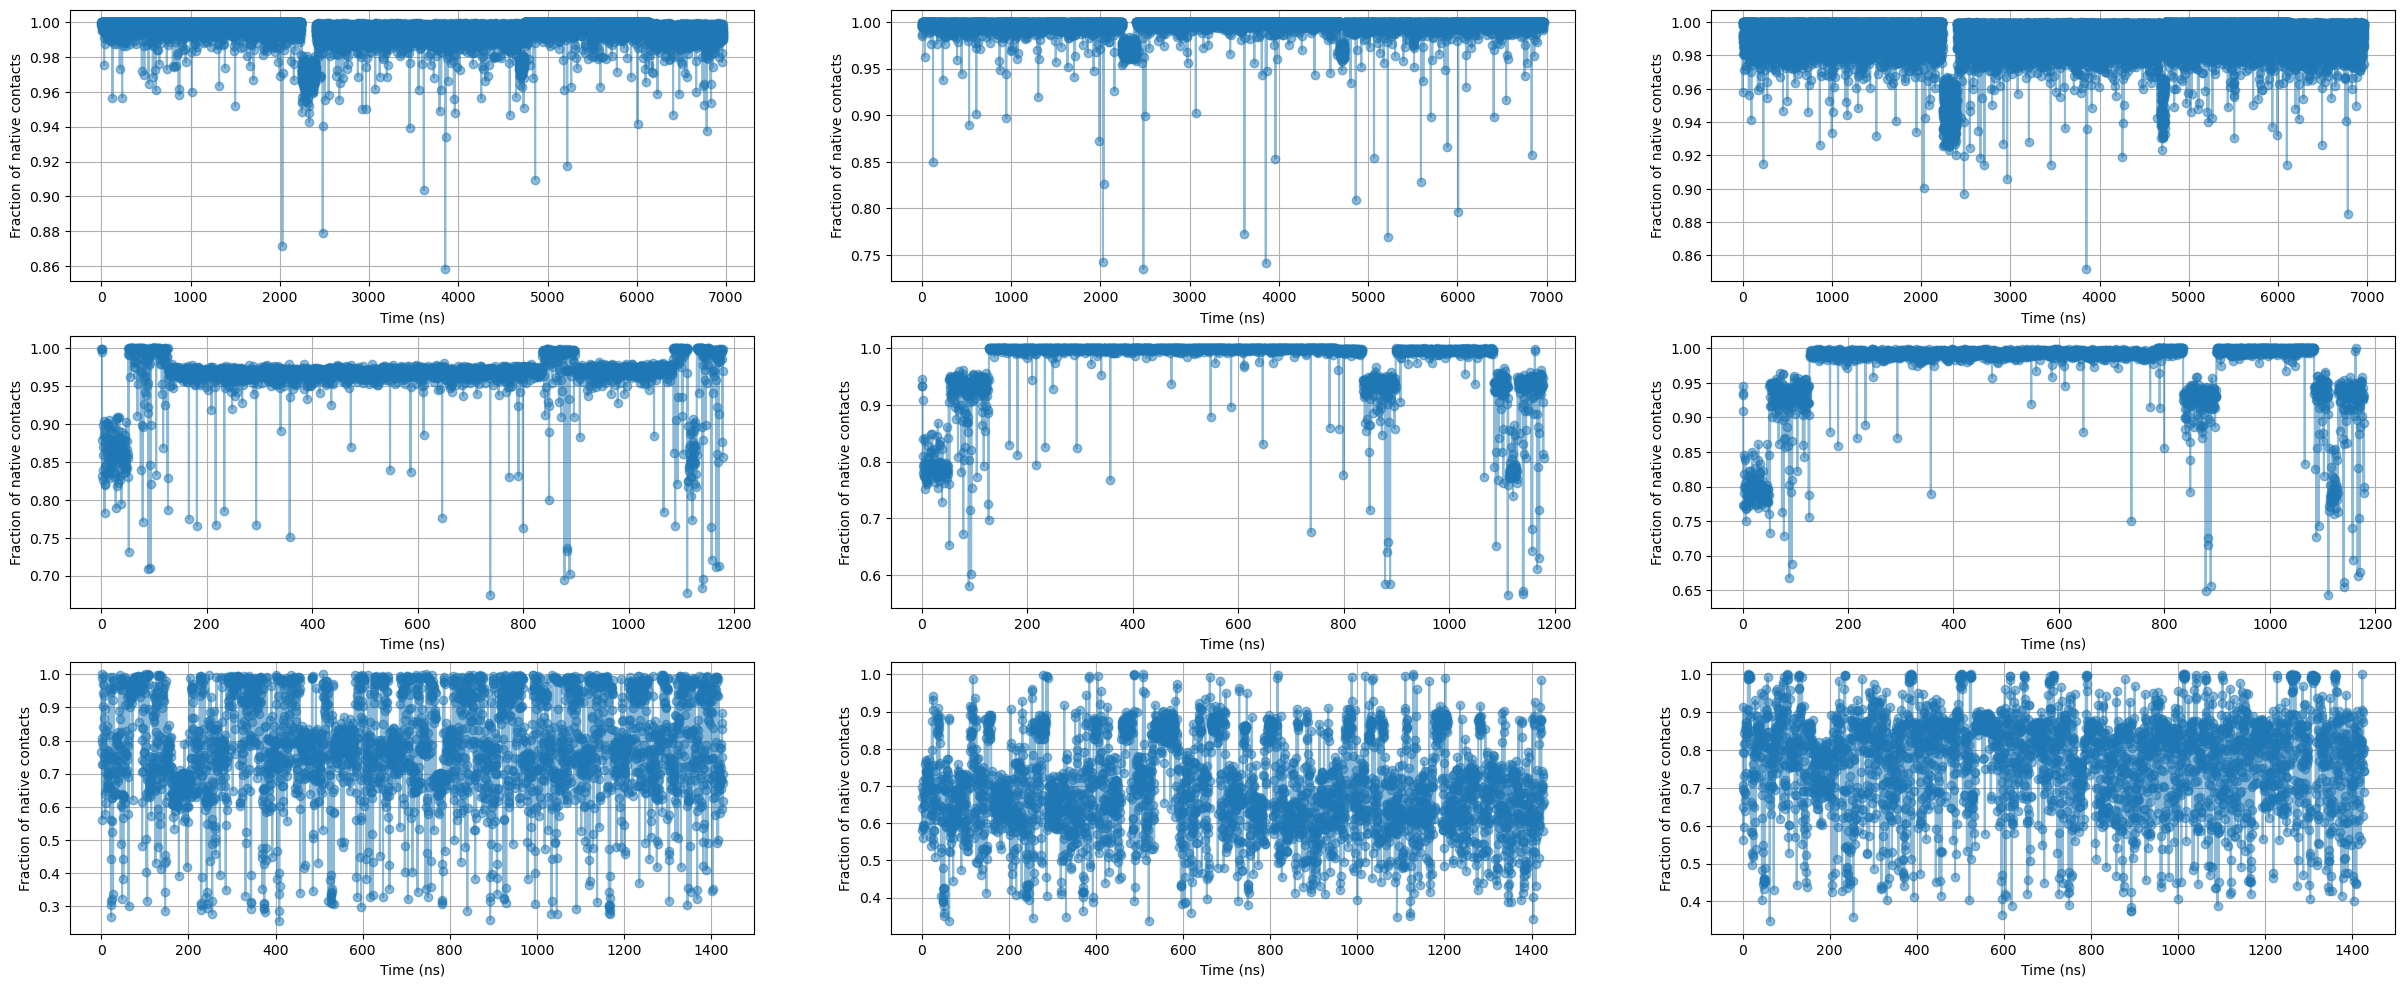

In [591]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30, 12))

for natcons, axi in zip(natcons1, axs):
    for natcon, ax in zip(natcons, axi):
        ax.plot(natcon[0]*0.4, natcon[1], marker='o', alpha=0.5)
        ax.grid(True)
        ax.set_xlabel("Time (ns)")
        ax.set_ylabel("Fraction of native contacts")

In [695]:
bin_natcons1 = [nc.bin_frames(natcon1, bins=np.shape(natcon1)[-1]//20, range=natcon_range) for natcon1, natcon_range in zip(natcons1, [(0.9, 1.0), (0.8, 1.0), (0.3, 1.0)])]

In [698]:
nc_cuts1 = [nc.get_cuts(bin_natcon1, max_components=5, height=1) for bin_natcon1 in bin_natcons1]

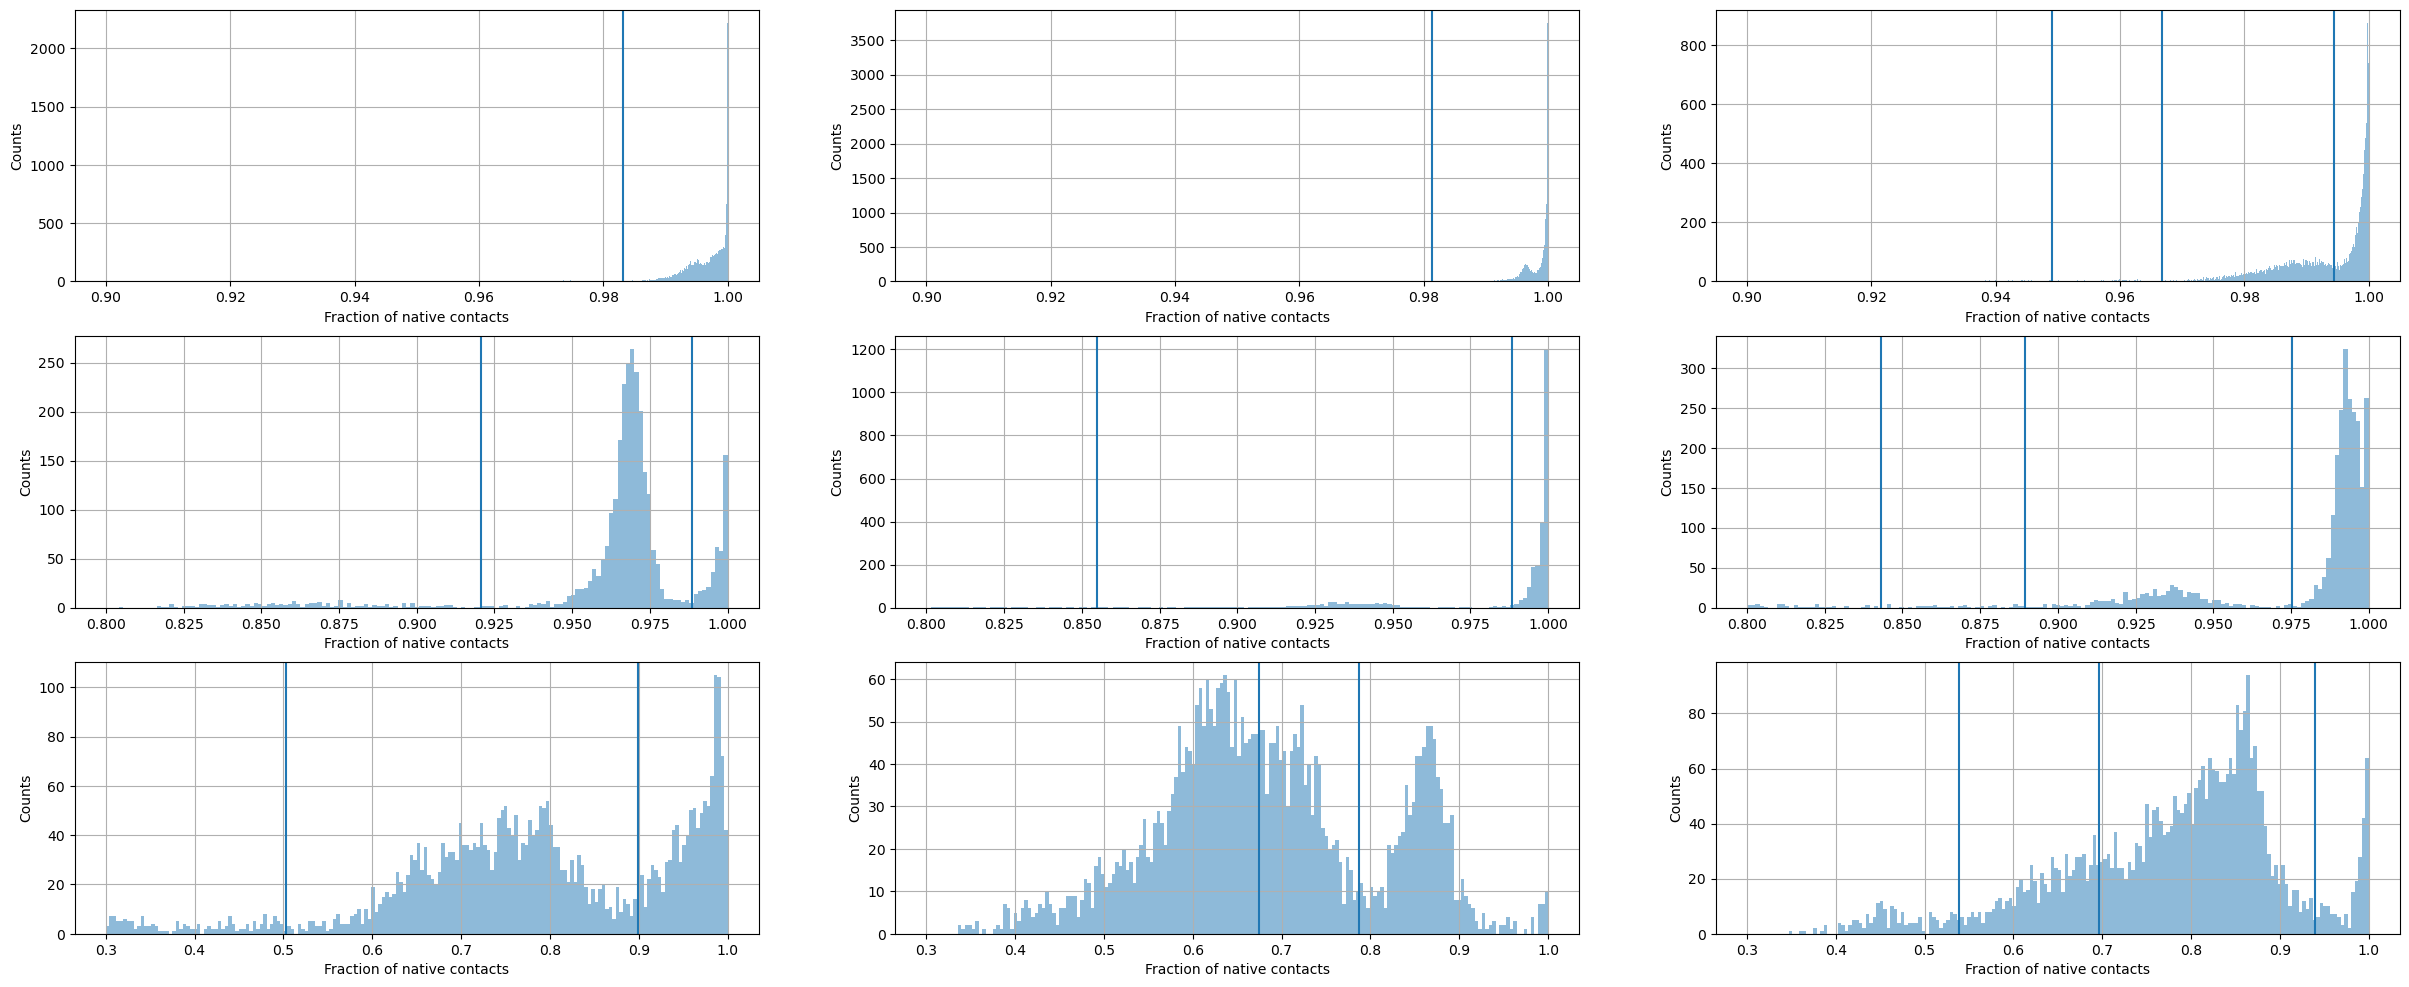

In [699]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(30, 12))

for bin_natcons, nc_cuts, axi in zip(bin_natcons1, nc_cuts1, axs):
    for bin_natcon, nc_cut, ax in zip(bin_natcons, nc_cuts, axi):
        bin_centers = (bin_natcon[1][1:] + bin_natcon[1][:-1]) / 2
        bin_width = bin_centers[1] - bin_centers[0]
        ax.bar(bin_centers, bin_natcon[0], alpha=0.5, width=bin_width)
        ax.grid(True)
        for cut in nc_cut:
            if cut > 0 :
                ax.axvline(cut)
        ax.set_xlabel("Fraction of native contacts")
        ax.set_ylabel("Counts")
        

What was difficult to separate via RMSD is clearly separable by native contacts analyses. Hence a combination of the two can actually serve as a good method to separate different structures. Of course, information regarding which contacts are present is missing. A good way to deal with this is to set the flag `post_process` in the `NativeContactsAnalysis.get_similarity_metric` to `False`. This way one would actually obtain scores of individual contacts as opposed to the average. This can be treated as a feature vector and used to obtain better resolution.

In [ ]:
# Using refs[0] and the corresponding RMSD - rmsds1[0] for analyses
nc_cuts = np.append([0], np.array(nc_cuts1[2])[np.not_equal(nc_cuts1[2], None)])
rmsds = rmsds1[0]
peaks = [np.where(np.logical_and(np.less(rmsds, high), np.greater_equal(rmsds, low)))[0] for low, high in zip(cuts[:4], cuts[1:5])]

In [ ]:
cluster_counter = 1
c_traj_paths = []
for peak in peaks:
    u = mda.Universe(top, coords[peak])
    
    for ts, pos in zip(u.trajectory, coords[peak, :, :]):
        ts.positions = pos
    
    with mdawriter("cluster" + str(cluster_counter) +".nc", u.atoms.n_atoms) as w:
        for ts in u.trajectory:
            w.write(u)

    c_traj_paths.append(Path.cwd().joinpath("cluster" + str(cluster_counter) +".nc").as_posix())
    
    cluster_counter += 1